$$ \Large \underline
{\textbf{Problema 2}}
$$

Determine la deformación y los esfuerzos principales en función de la posición para una chapa con
un agujero en el centro sujeta a tracción por sus extremos, como se muestra en la figura. Las
dimensiones de la chapa son de $20\ x\ 10\ pulgadas$ y su espesor de $1\ pulgada$. El radio del agujero
central es también de $1\ pulgada$. Tome $E = 30 x 10^{6}\
 psi$ y $n = 0.30$.


Analice el problema con número creciente de elementos y estudie su convergencia. 

<center><img src="ImgProb02G03.png"></center>

In [1]:
import gmsh
import numpy as np
import matplotlib.pyplot as plt
import MEF as mef

In [2]:
lc = 0.3
h = 10  # in
b = 20  # in
v = 0.3  # coef Poisson
Ei = 30e6  # psi
r = 1  # in  radio del agujero
t = 1  # in  espesor de la chapa
T = 1000

In [3]:
gmsh.initialize()

In [4]:
gmsh.model.add('Chapa_agujero_central')

In [5]:
pc = gmsh.model.geo.addPoint(0,0,0,lc)
p1 = gmsh.model.geo.addPoint(r,0,0,lc/15)
p2 = gmsh.model.geo.addPoint(b/2,0,0,lc)
p3 = gmsh.model.geo.addPoint(b/2,h/2,0,lc)
p4 = gmsh.model.geo.addPoint(0,h/2,0,lc)
p5 = gmsh.model.geo.addPoint(0,r,0,lc/15)

In [6]:
l1 = gmsh.model.geo.addLine(p1,p2)
l2 = gmsh.model.geo.addLine(p2,p3)
l3 = gmsh.model.geo.addLine(p3,p4)
l4 = gmsh.model.geo.addLine(p4,p5)
c1 = gmsh.model.geo.addCircleArc(p5, pc, p1)

In [7]:
C1 = gmsh.model.geo.addCurveLoop([l1,l2,l3,l4,c1])

In [8]:
S1 = gmsh.model.geo.addPlaneSurface([C1])

In [9]:
gmsh.model.geo.synchronize()

La linea vertical de la izquierda no se movera en la dirección x por simetria, ya que se aplica la misma tension de ambos lados. 

La linea horizontal de aba no se movera en la dirección y, también por simetria. 

In [10]:
Empotrado_x = gmsh.model.addPhysicalGroup(1, [l4])
gmsh.model.setPhysicalName(1,Empotrado_x,'Empotrado en x')
Empotrado_y = gmsh.model.addPhysicalGroup(1, [l1])
gmsh.model.setPhysicalName(1,Empotrado_y,'Empotrado en y')

Traccionado = gmsh.model.addPhysicalGroup(1,[l2])
gmsh.model.setPhysicalName(1,Traccionado,'Traccionado')

Superficie = gmsh.model.addPhysicalGroup(2,[S1])
gmsh.model.setPhysicalName(2,Superficie,'Superficie')

In [11]:
gmsh.model.mesh.generate(2)
gmsh.model.geo.synchronize()
gmsh.fltk.run()

In [12]:
NodeInfo = gmsh.model.mesh.get_nodes()
Nn = NodeInfo[0].shape[0]
ETAGS, ELEMENTS = gmsh.model.mesh.get_elements_by_type(2)   # ETAGS = numeracion de cada elemento
                                                            # ELEMENTS = ravel de los nodos que posee cada elemento
MN = NodeInfo[1].reshape(Nn,3)  # matriz coordenadas de los nodos
MN = np.append(MN[1:,:],[np.zeros(3)],0)  # llevo la primer fila al final porque nombra al nodo del centro como el último taggeado
MC = ELEMENTS.reshape(ETAGS.shape[0],3)  # matriz conectividad

In [13]:
Ne, Nnxe = MC.shape

In [14]:
E = np.zeros(Ne)
for e in range(Ne):
    E[e] = Ei

In [15]:
MC = MC - np.ones([Ne,Nnxe])  # resto 1 para acomodar a lenguaje python

In [16]:
gmsh.option.setNumber("Mesh.MshFileVersion",2.2)
gmsh.write('chapa_agujero.msh')

In [17]:
glxn = 2
dimension_elementos = 2

In [18]:
K, Ke, D, B = mef.Kglobal_barra(MN, MC, E, glxn, dimension_elementos, v,t) 

In [19]:
nodos_empot_x, xyz_empot_x = gmsh.model.mesh.getNodesForPhysicalGroup(1, Empotrado_x)
nodos_empot_y, xyz_empot_y = gmsh.model.mesh.getNodesForPhysicalGroup(1, Empotrado_y)

In [20]:
s = []

for n in nodos_empot_x-1:
    s.append(glxn*n)
for n in nodos_empot_y-1:
    s.append(glxn*n+1)

s.append((NodeInfo[0][0]-1)*glxn)
s.append((NodeInfo[0][0]-1)*glxn+1)

s = np.array(s).astype(int)

Us = np.zeros([s.shape[0]]).reshape([-1,1])

In [21]:
r = mef.vector_complemento(s, MN, glxn).astype(int)

In [22]:
entityTraccionada = gmsh.model.getEntitiesForPhysicalGroup(1, Traccionado)
Tgroup, Ttraccionada, Ltraccionada = gmsh.model.mesh.getElements(1, entityTraccionada[0])
Nlineastraccionadas = len(Ttraccionada[0])
MCtraccionadas = Ltraccionada[0].reshape(Nlineastraccionadas,2)-1

In [23]:
Fr = np.zeros_like(r)
for e in range(Nlineastraccionadas):
    nodo1 = MCtraccionadas[e,0].astype(int)
    nodo2 = MCtraccionadas[e,1].astype(int)
    Ltraccionado = abs(MN[nodo2,1]-MN[nodo1,1])
    Fr[np.where(r == nodo1*2)[0][0]] += T*Ltraccionado*t/2
    Fr[np.where(r == nodo2*2)[0][0]] += T*Ltraccionado*t/2
Fr = Fr.reshape([-1,1])

In [24]:
F, U = mef.solve(K, r, s, Us, Fr)

In [25]:
sig = {}
d = {}
for e in range(Ne):
    nodo = MC[e,:].astype(int)
    d[e] = np.array([U[nodo[0]*glxn],U[nodo[0]*glxn+1],
                     U[nodo[1]*glxn],U[nodo[1]*glxn+1],
                     U[nodo[2]*glxn],U[nodo[2]*glxn+1]]).reshape([-1,1])
    sig[e] = D[e].dot(B[e].dot(d[e]))

In [26]:
U2D = U.reshape(Nn,glxn)
U3D = np.append(U2D,np.zeros(U2D.shape[0]).reshape([-1,1]),1)

In [27]:
MNdef = MN + U3D*1e4  # se exagera la deformación 

Text(0.5, 0, 'desplazamiento en x')

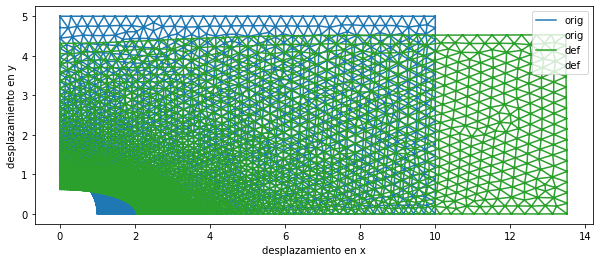

In [28]:
fig, ax = plt.subplots(figsize=(10,4))
plt.triplot(MN[:,0], MN[:,1], MC, label='orig')  # triplot = grafica triangulitos
plt.triplot(MNdef[:,0], MNdef[:,1], MC, label='def')
plt.legend()
plt.ylabel('desplazamiento en y')
plt.xlabel('desplazamiento en x')

In [29]:
desps = gmsh.view.add("Desplazamientos")
Desps = gmsh.view.addModelData(desps, 0, 'Chapa_agujero_central', 'NodeData', NodeInfo[0], U3D, numComponents=3)
gmsh.option.setNumber(f'View[{desps}].VectorType',5)

F2D = F.reshape(Nn,glxn)
F3D = np.append(F2D,np.zeros(F2D.shape[0]).reshape([-1,1]),1)

fuerzas = gmsh.view.add('Fuerzas')
Fuerzas = gmsh.view.addModelData(fuerzas, 0, 'Chapa_agujero_central','NodeData',NodeInfo[0], F3D, numComponents=3)
gmsh.option.setNumber(f'View[{fuerzas}].VectorType',4)
gmsh.option.setNumber(f'View[{fuerzas}].GlyphLocation',2)

sig_xytau = np.hstack(list(sig.values()))  # saco las tensiones del diccionario, quedan en filas para cada elemento las tensiones x, y, xy

sigx = gmsh.view.add('Tensiones en x')
sigy = gmsh.view.add('Tensiones en y')
sigxy = gmsh.view.add('Tensiones xy')
SIGX = gmsh.view.addModelData(sigx, 0, 'Chapa_agujero_central', 'ElementData', ETAGS, sig_xytau[0,:].reshape([-1,1]), numComponents=1) # hago reshape porque tienen que ir vectores columnas
SIGY = gmsh.view.addModelData(sigy, 0, 'Chapa_agujero_central', 'ElementData', ETAGS, sig_xytau[1,:].reshape([-1,1]), numComponents=1)

gmsh.fltk.run()

$$
$$

$$ \Large
\textbf{Se muestran los resultados obtenidos:}
$$

<center><img src="ImgProb02_tensionesenx.png"></center>

<center><img src="ImgProb02_tensioneseny.png"></center>

Se observa que la mayor concentración de tensiones ocurre en la parte superior del agujero y por simetria también ocurrirá en la parte inferior.